Start with the necessary imports and reading the datasets of github:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

dataset91 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short91_f1_000.csv.gz',index_col=False)
dataset92 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short92_e2_000.csv.gz',index_col=False)
dataset93 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short93_d2_000.csv.gz',index_col=False)
dataset94 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short94_c2_000.csv.gz',index_col=False)

The goal of this exercise is to find a particle using invariant mass. This can be done by checking which invariant masses are produced by the particle accelerator. If there area a lot of datapoints for a specific invariant mass that means there's a particle. Since the dataset does not have invariant mass, we have to calculate it ourselves. To do that we first need pseudorapidities for both particles which we can calculate from formula:

$$
\eta = -\ln(\tan(\frac{\theta}{2}))
$$


Now using pseudorapidities we can calculate the invariant mass:

$$
M = \sqrt{2p_{T1}p_{T2}( \cosh(\eta_1-\eta_2)-\cos(\phi_1-\phi_2) )}
$$

In [2]:
dataset91["ETA1"] = - np.log(np.tan(dataset91.THETA1/2))
dataset91["ETA2"] = - np.log(np.tan(dataset91.THETA2/2))
dataset91["M"] = np.sqrt(2*dataset91.PT1*dataset91.PT2*(np.cosh(dataset91.ETA1 - dataset91.ETA2) - np.cos(dataset91.PHI1 - dataset91.PHI2)))

Now we need to define the integrated luminosity for each event. Luminosity is defined as

$$
L = \dfrac{1}{\sigma} \dfrac{dN}{dt}
$$

meaning it is the rate of events divided by cross-section. Cross-section describes the probability of the colliding particles actually causing a reaction. Therefore integraded luminosity is just the total number of events divided by the cross-section. Because the luminosity can be different for different values of center-of-mass energy (ECM) we would get a weighted diagram since a large luminosity naturally produces a lot of results meaning a lot of invariant mass values. This could distrubt our ability to recognise which invariant mass values are actually produced often. Therefore we want to calculate which invariatn mass values are common in proportion to the amount of reactions we have. This can be done just by weighting the histogram by the inverse of luminosity. 

Since each center-of-mass energy (ECM) value has a different luminosity we need to find all ECM values and that can be done by using .ECM.unique() function on the dataset. From that we can see some values that are quite close to each other. This is beccause of noise in the measurement and can be ignored. Doing that we find that there are 7 different values for ECM. Using the table given we can assing a luminosity to each datapoint in the dataset by doing the following. This is done by first sorting the dataset by ECM, then finding the point in which ECM value changes using .index[0]. Lastly the values can be assigned using .loc where we can specify rows and columns which we want to assign the value to. 

In [7]:
#values sorted by ECM (for convenience of programming)
dataset91 = dataset91.sort_values(['ECM']) 
dataset91 = dataset91.reset_index(drop = True) #correct index after sort

#section 1: 
slice_index1 = dataset91[dataset91.ECM == 89.506].index[0] 
lum1 = 629 #luminosity for this section
dataset91.loc[0:slice_index1-1, "LUM"] = lum1

#section 2: 
slice_index2 = dataset91[dataset91.ECM == 90.256].index[0] 
lum2 = 647 #luminosity for this section
dataset91.loc[slice_index1:slice_index2-1, "LUM"] = lum2

#section 3: 
slice_index3 = dataset91[dataset91.ECM == 91.25].index[0] 
lum3 = 633 #luminosity for this section
dataset91.loc[slice_index2:slice_index3-1, "LUM"] = lum3

#section 4: 
slice_index4 = dataset91[dataset91.ECM == 92.004].index[0] 
lum4 = 2274 #luminosity for this section
dataset91.loc[slice_index3:slice_index4-1, "LUM"] = lum4

#section 5: 
slice_index5 = dataset91[dataset91.ECM == 93.015].index[0] 
lum5 = 680 #luminosity for this section
dataset91.loc[slice_index4:slice_index5-1, "LUM"] = lum5

#section 6: 
slice_index6 = dataset91[dataset91.ECM == 93.765].index[0] 
lum6 = 634 #luminosity for this section
dataset91.loc[slice_index5:slice_index6-1, "LUM"] = lum6

#section 7: 
lum7 = 492 #luminosity for this section
dataset91.loc[slice_index6:, "LUM"] = lum7


Important note: Making copies of each section, changing them and then creating a new dataset from the copies is incredibly inefficient, but much easier to understand in my opinion. Since we are making something that could be used for education, I'm going to write this method in this comment for now. It's far easier to understand than .loc which is just a niche feature of pandas. The result is exactly the same.

section 1:

slice_index1 = dataset91[dataset91.ECM == 89.506].index[0]

section1 = dataset91[0:slice_index1]

lum_lst88 = 711.1 #luminosity for this section

section1["Normalised"] = np.divide(section1.M, lum_lst88)

at the end combine sections:

dataset91 = [section1, section2, section3,...]

Next we create a histogram of the invariant masses. As previously covered the historgram should be weighted 1/luminosity

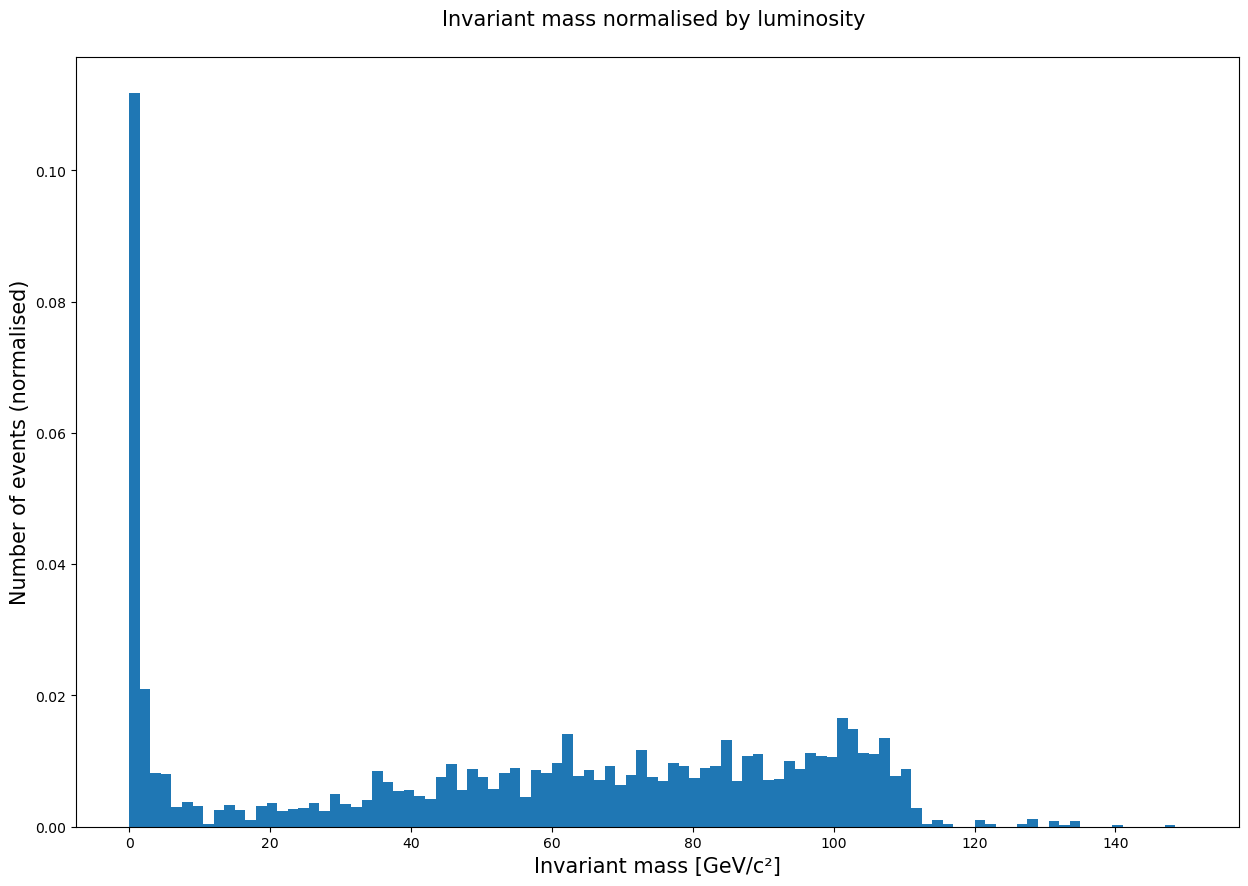

In [4]:
#weighted by luminosity
fig = plt.figure(figsize=(15, 10))
plt.hist(dataset91.M, bins=100, range=(0,150), weights = 1/dataset91.LUM, density = True)

plt.xlabel('Invariant mass [GeV/c²]', fontsize=15)
plt.ylabel('Number of events (normalised)', fontsize=15)
plt.title('Invariant mass normalised by luminosity \n', fontsize=15) 

plt.show()

Come up with some good way of explaining this mess!!!!!

The values and the uncertainties from the optimization:

The value of the decay width = 2.9575912862347713 +- 2.3034125647131707
The value of the maximum of the distribution = 101.96123785665898 +- 0.6799537391144158
a = 0.0001855676087263158 +- 0.00011496087457918129
b = 0.004342666556108096 +- 0.009605426418016556
A = 0.07654506885060994 +- 0.05173063614298418


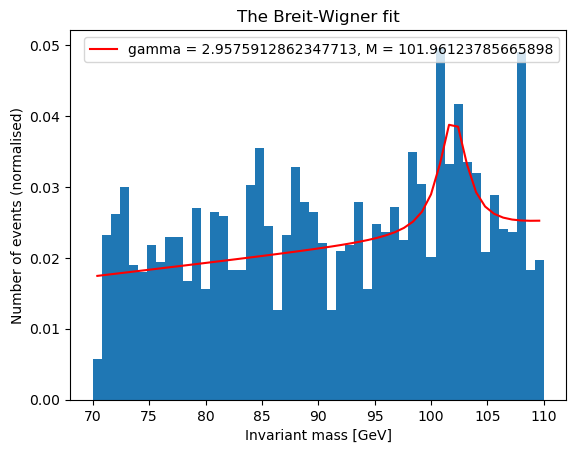

In [5]:
#limit to where Z-boson should be:
lowerlimit = 70
upperlimit = 110
bins = 50

#Histogram of that area
limitedmasses = dataset91[(dataset91.M > lowerlimit) & (dataset91.M < upperlimit)]
histogram = plt.hist(limitedmasses.M, bins=bins, range=(lowerlimit,upperlimit), weights = 1/limitedmasses.LUM, density = True)


def breitwigner(E, gamma, M, a, b, A):
    return a*E+b+A*( (2*np.sqrt(2)*M*gamma*np.sqrt(M**2*(M**2+gamma**2)))/(np.pi*np.sqrt(M**2+np.sqrt(M**2*(M**2+gamma**2)))) )/((E**2-M**2)**2+M**2*gamma**2)

#Initial guesses:
initials = [3, 100, 4, 2, 100]

#use the histogram to make a function:
y = histogram[0]
x = 0.5*(histogram[1][0:-1] + histogram[1][1:])
best, covariance = curve_fit(breitwigner, x, y, p0=initials, sigma=np.sqrt(y))
error = np.sqrt(np.diag(covariance))
    
#Values from optimization:
print("The values and the uncertainties from the optimization:")
print("")
print("The value of the decay width = {} +- {}".format(best[0], error[0]))
print("The value of the maximum of the distribution = {} +- {}".format(best[1], error[1]))
print("a = {} +- {}".format(best[2], error[2]))
print("b = {} +- {}".format(best[3], error[3]))
print("A = {} +- {}".format(best[4], error[4]))


#plot graph:
plt.plot(x, breitwigner(x, *best), 'r-', label='gamma = {}, M = {}'.format(best[0], best[1]))
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Number of events (normalised)')
plt.title('The Breit-Wigner fit')
plt.legend()
plt.show()

Mostly because I was interested to see what would happen here is the same plot but with half of the datapoints missing. I removed all the ones with large pseudorapidities since they are less accurate. Does not seem to change much. 

732
332
The values and the uncertainties from the optimization:

The value of the decay width = 1.6852899017026737 +- 0.99350849203215
The value of the maximum of the distribution = 102.11766265889729 +- 0.2765691653232274
a = 0.00011629965637023451 +- 8.014212394554169e-05
b = 0.011791560489557188 +- 0.006909100518215951
A = 0.06249931440752245 +- 0.02609400412978618


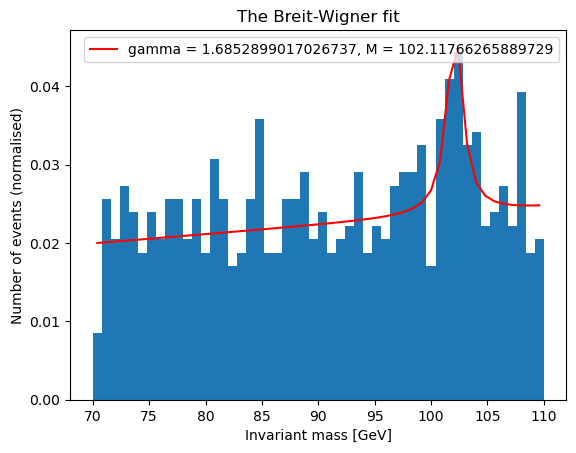

In [6]:
pseudorapidity_limit = 0.5
print(len(limitedmasses))
limited_pseudorapidies = limitedmasses[(abs(limitedmasses.ETA1) < 0.05) & (abs(limitedmasses.ETA2) < 0.05)]
print(len(limited_pseudorapidies))
histogram = plt.hist(limitedmasses.M, bins=bins, range=(lowerlimit,upperlimit), density = True)


def breitwigner(E, gamma, M, a, b, A):
    return a*E+b+A*( (2*np.sqrt(2)*M*gamma*np.sqrt(M**2*(M**2+gamma**2)))/(np.pi*np.sqrt(M**2+np.sqrt(M**2*(M**2+gamma**2)))) )/((E**2-M**2)**2+M**2*gamma**2)

#Initial guesses:
initials = [1.5, 100, 0, 2, 100]

#use the histogram to make a function:
y = histogram[0]
x = 0.5*(histogram[1][0:-1] + histogram[1][1:])
best, covariance = curve_fit(breitwigner, x, y, p0=initials, sigma=np.sqrt(y))
error = np.sqrt(np.diag(covariance))
    
#Values from optimization:
print("The values and the uncertainties from the optimization:")
print("")
print("The value of the decay width = {} +- {}".format(best[0], error[0]))
print("The value of the maximum of the distribution = {} +- {}".format(best[1], error[1]))
print("a = {} +- {}".format(best[2], error[2]))
print("b = {} +- {}".format(best[3], error[3]))
print("A = {} +- {}".format(best[4], error[4]))


#plot graph:
plt.plot(x, breitwigner(x, *best), 'r-', label='gamma = {}, M = {}'.format(best[0], best[1]))
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Number of events (normalised)')
plt.title('The Breit-Wigner fit')
plt.legend()
plt.show()